<a href="https://colab.research.google.com/github/vadim-privalov/Sorevnovania/blob/main/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%82%D0%B2%D0%B8%D1%82%D0%BE%D0%B2_%D0%9A%D0%B0%D0%B3%D0%B3%D0%BB_%D1%81%D0%BE%D1%80%D0%B5%D0%B2%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Определение тональности текста. Цель состоит в том, чтобы определить тональность текста на основе предоставленных данных. Данные представляют набор текстовых данных отзывов на покупку мобильных телефонов и аксессуаров. Где 1 — сообщение о катастрофе, 0 — нет.

Загрузите из датасета текстовую базу сообщений из Твиттера, а также базу для тестирования. Подайте дата сет в нейронную сеть, постаравшись добиться максимальной точности распознавания. Для улучшения обучения можно использовать также дополнительные методы, не рассмотренные в занятиях, слои, функции активации, менять параметры оптимизатора Adam и прочие гипер параметры. Результаты рекомендуется заносить в таблицу для себя, чтобы можно было потом воспроизвести лучший вариант. Предсказание Вашей сети необходимо отправить в виде специального файла с расширением csv, чтобы войти в рейтинговую таблицу соревнования. Ответ можно улучшить и подавать результат несколько раз.

Столбцы
id - уникальный идентификатор для каждого твита
text - текст твита
location - место, откуда был отправлен твит (может быть пустым)
keyword - конкретное ключевое слово из твита (может быть пустым)
target- только в train.csv это означает, относится ли твит к настоящей катастрофе ( 1) или нет ( 0)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from google.colab import files

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf # импортируем tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import zipfile # для работы с архивами zip

import os
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline
# устанавливаем свежий Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import os

from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from bs4 import BeautifulSoup
!pip install contractions
import contractions
from textblob import TextBlob
import spacy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def Init_Kaggle():
    try:
        # Создаём правильную папку для ключа Каггл
        # в Колабе, она должна быть такой по требованию Каггл
        !mkdir ~/.kaggle
        # переходим в папку, теперь это путь по умолчанию
        %cd ~/.kaggle
        # запускаем - подключаем Google Drive - будем скачивать с него, так намного быстрее и удобнее
        # после запуска переходим по ссылке, которая появится, для идентификации
        # копируем оттуда код authorization code и вставляем здесь в окошко
        drive.mount('/content/drive')
        # нужно зарегистрироваться на Каггл и скачать ключ для взаимодействия с API
        # соревновательной системы Каггла kaggle.json. Нужно скопировать его в папку
        # Google Drive, предварительно её создав: /content/drive/My Drive/datasets/kaggle/
        !cp '/content/drive/MyDrive/datasets/kaggle/kaggle.json' '/root/.kaggle/kaggle.json'
        # выводим версию API Kaggle:
        !kaggle --version
        !ls
        print(' Ключи Kaggle успешно установлены! ')
    except:
        print(' При установке ключей Kaggle произошла ошибка! ') 

In [ ]:
def Load_data_from_Kaggle():
    # считаем заполненную базу данных из kaggle
    %cd ~/.kaggle
    print('скачиваем данные с Каггл:')
    !kaggle competitions download -c nlp-getting-started
    print('загружаем из архива, распаковываем:')
    z = zipfile.ZipFile('nlp-getting-started.zip', 'r')
    z.extractall()
    # удаляем архив, чтобы не занимал место на диске
    !rm nlp-getting-started.zip
    #Считываем данные с помощью pandas из двух файлов
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    return train, test

In [ ]:
Init_Kaggle() # устанавливаем кючи кагл

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/root/.kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kaggle API 1.5.12
Conv1D_Model.png  kaggle.json  sample_submission.csv  test.csv	train.csv
 Ключи Kaggle успешно установлены! 


In [ ]:
train, test = Load_data_from_Kaggle() # считаем заполненную базу данных из kaggle
train.head()

/root/.kaggle
скачиваем данные с Каггл:
  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 50.4MB/s]
загружаем из архива, распаковываем:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# выведем информацию о колонках
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7613 non-null   int64 
 1   keyword      7552 non-null   object
 2   location     5080 non-null   object
 3   text         7613 non-null   object
 4   target       7613 non-null   int64 
 5   is_positive  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


In [ ]:
# посмотрим, сколько у нас отзывов с какими оценками
reviews['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
def Data_Update(reviews): #преодбработка данных
    global NUM_WORDS
    global tokenizer
    # создадим словарь для преобразования оценки из шкалы  5-1 в  шкалу positive - negative
    # используем 0 для класса негативных отзывов, 1 для класса позитивных отзывов
    label_to_binary = {1: 1, 0: 0}
    # создадим новую колонку в DataFramкe
    reviews['is_positive'] = reviews['target'].apply(lambda x: label_to_binary[x])
    # выделим наши тексты (признаковые описания) и класс, который нужно предсказывать
    X = reviews['text']
    Y = reviews['is_positive']
    # разделим наши данные на обучающую и валидационную выборки
    train_index, val_index = train_test_split(np.arange(reviews.shape[0]))
    x_train_raw, x_val_raw = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index] 
    NUM_WORDS = 300 # константа, максимальное количество слов, которые будет учитывать наша модель

    # создадим наш Токенайзер
    tokenizer = Tokenizer(num_words=NUM_WORDS, # максимальное количество слов, которые будет учитывать наш токенайзер
                        filters='"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', # символы, которые он токенайзер будет фильтровать
                        lower=True,  #приводятся ли все символы к нижнему регситру
                        split=' ',  # символ, по которому происходит разделение на слова (токены)
                        char_level=False,  # являются ли токенами отдельные буквы
                        oov_token='UNKNOWN' # токен для неизвестных слов 
                        )
    tokenizer.fit_on_texts(x_train_raw) # обучим наш токенайзер на обучающих текстах
    # Преобразуем наши текстовые данные в формат One Hot Encoding
    x_train_01 = tokenizer.texts_to_matrix(x_train_raw)
    x_val_01 = tokenizer.texts_to_matrix(x_val_raw)
    return x_train_01, y_train, x_val_01, y_val

In [ ]:
x_train_01, y_train, x_val_01, y_val = Data_Update(reviews)

In [ ]:
x_train_01.shape

(5709, 300)

# Создание и обучение модели

In [ ]:
# создадим простую модель с полносвязными слоем
def Dense_model():
    model01 = Sequential()
    model01.add(Dense(6000, input_dim=NUM_WORDS, activation='relu'))
    model01.add(BatchNormalization())
    model01.add(Dropout(0.3))
    model01.add(Dense(3000 ,activation='tanh'))
    model01.add(Dense(1000 ,activation='tanh'))
    model01.add(Dropout(0.2))
    model01.add(Dense(100 ,activation='relu'))
    model01.add(Dense(1 ,activation='sigmoid'))
    model01.compile(optimizer=Adam(learning_rate=0.001),  loss='binary_crossentropy',  metrics=['accuracy'])

    return model01

In [ ]:
# обучим нашу модель
model_text_tonality = Dense_model()
model_text_tonality.fit(x = x_train_01,  y = y_train, epochs = 150, verbose = 1, validation_data= (x_val_01, y_val))

Epoch 1/150
179/179 [==============================] - 10s 31ms/step - loss: 0.7229 - accuracy: 0.7061 - val_loss: 0.5453 - val_accuracy: 0.7290
Epoch 2/150
179/179 [==============================] - 5s 29ms/step - loss: 0.3948 - accuracy: 0.8327 - val_loss: 0.6508 - val_accuracy: 0.7658
Epoch 3/150
179/179 [==============================] - 5s 30ms/step - loss: 0.2608 - accuracy: 0.8921 - val_loss: 0.6399 - val_accuracy: 0.7694
Epoch 4/150
179/179 [==============================] - 5s 29ms/step - loss: 0.1652 - accuracy: 0.9327 - val_loss: 0.7074 - val_accuracy: 0.7910
Epoch 5/150
179/179 [==============================] - 5s 30ms/step - loss: 0.1285 - accuracy: 0.9539 - val_loss: 1.0109 - val_accuracy: 0.7883
Epoch 6/150
179/179 [==============================] - 5s 30ms/step - loss: 0.1007 - accuracy: 0.9604 - val_loss: 1.0391 - val_accuracy: 0.7595
Epoch 7/150
179/179 [==============================] - 5s 31ms/step - loss: 0.0985 - accuracy: 0.9592 - val_loss: 1.0218 - val_accuracy

In [ ]:
# сохраним модель 
model_text_tonality.save('/content/drive/MyDrive/datasets/model_text_tonality_01.h5') 

In [ ]:
model_text_tonality = load_model('/content/drive/MyDrive/datasets/model_text_tonality_01.h5') # загрузим модель по необходимости

In [ ]:
def Prediction_model(test_data): # предсказываем значения
    try:
        # x_test_raw = pd.Series(test_data_reviews)
        x_test_raw = test_data['text']
        x_test_tok = tokenizer.texts_to_matrix(x_test_raw)
        
        # получим предсказания модели
        pred = model_text_tonality.predict(x_test_tok)
        pred = np.round(pred).astype(np.int)
        print('Прогноз тестовых данных сформирован успешно!')
        return pred 
    except:
        print('При формировании прогноза на тестовых данных произошла ошибка!')
        return 0

In [ ]:
# оформить результат и отправить на Kaggle
def Send_results(pred_data_my):
    try:
        predUnscaled = pred_data_my.squeeze()
        # создаём датафрейм в нужном формате
        submission = pd.DataFrame({"Id":range(1,len(predUnscaled)+1),"target":predUnscaled})
        
        submission.head()
        # сохраняем его как csv
        sample_submission = submission.to_csv('/content/drive/MyDrive/datasets/nlp-getting-started/sample_submission.csv', sep=',', index=False, header=True)
        # отправляем на соревнование
        !kaggle competitions submit -c nlp-getting-started -f sample_submission.csv -m "Message"
        print('\n Расчитанные данные успешно отправлены! ')
        
    except:
        print('Отправка расчетных данных не прошла! ')  

In [ ]:
prediction_data = Prediction_model(test_data) # получим прогноз на тестовой выбоке

Прогноз тестовых данных сформирован успешно!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [ ]:
Send_results(prediction_data) # оформить результат и отправить на Kaggle

100% 22.2k/22.2k [00:01<00:00, 12.2kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets
 Расчитанные данные успешно отправлены! 


# Вариант 2


In [ ]:
!pip install -q pymorphy2 # установим библиотеку pymorphy 

In [ ]:
# импортируем специализированные библиотеки nltk, pymorphy2 и gensim
# это специализированные библиотеки для работы с естественным языком
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer

import pymorphy2

from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
import gensim.downloader as api

nltk.download('stopwords')
nltk.download('punkt')

# из библиотеки Sklearn импортируем три наиболее популярных Vectorizer для работы с текстами
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Функции для очистки данных

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
global stopwords

def get_words_counts(tweets):
        length = len(str(tweets).split())
        return length
    
def get_chars_counts(tweets):
        string = tweets.split()
        x = ''.join(string)
        return len(x)
    
def get_average_word_length(tweets):
        count = get_chars_counts(tweets)/get_words_counts(tweets)
        return count
    
def get_stopwords_count(tweets):
        global stopwords
        stopwords = len([t for t in tweets.split() if t in stopwords])
        return stopwords
    
def get_hashtags_tags(tweets):
        hashtags = len([t for t in tweets.split() if t.startswith('#')])
        return hashtags
        
def get_email_tags(tweets):
        email = len([t for t in tweets.split() if t.startwith('@')])
        return email
    
def get_digit_counts(tweets):
        digits = re.findall(r'[0-9,.]+', tweets)
        return digits
    
def get_uppercase_units(tweets):
        uppercase = len([t for t in tweets.split() if t.isupper()])
        return uppercase

In [ ]:
# С помощью этой функции мы можем получить некоторые функции для сборки немного EDA
def get_features(df):
    if type(df) == pd.core.frame.DataFrame:
        df['words_counts'] = df['text'].apply(lambda x: get_words_counts(x))
        df['char_counts'] = df['text'].apply(lambda x: get_chars_counts(x))
        df['average_word_length'] = df['text'].apply(lambda x: get_average_word_length(x))
#        df['stopwords_counts'] = df['text'].apply(lambda x: get_stopwords_count(x))
        df['hashtags_counts'] = df['text'].apply(lambda x: get_hashtags_tags(x))
#        df['email_counts'] = df['text'].apply(lambda x: get_email_tags(x))
        df['digits_counts'] = df['text'].apply(lambda x: get_digit_counts(x))
        df['uppercase_counts'] = df['text'].apply(lambda x: get_uppercase_units(x))
        
    else:
        print('ERROR')
        
    return df


In [ ]:
train = pd.DataFrame(train)

In [ ]:
train = get_features(train)

In [ ]:
train


,id,keyword,location,text,target,words_counts,char_counts,average_word_length,hashtags_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,57,4.384615,1,[],1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,32,4.571429,0,[.],0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,112,5.090909,0,[.],0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,57,7.125000,1,"[13,000]",0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,72,4.500000,2,[],0
...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,73,6.636364,0,"[., 5]",0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,106,5.300000,0,"[., .]",0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,58,7.250000,0,"[1.94, 01, 04, 5, ., ., 8]",2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,119,6.263158,0,"[., .]",0


Разведочный анализ данных (**Exploratory Data Analysis**) – предварительное исследование Датасета (Dataset) с целью определения его основных характеристик, взаимосвязей между признаками, а также сужения набора методов, используемых для создания Модели (Model) Машинного обучения (Machine Learning).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


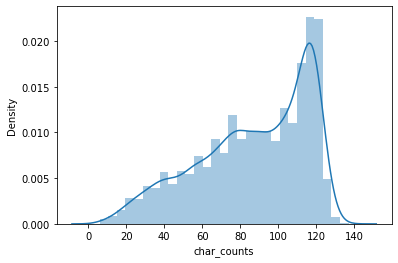

In [ ]:
sns.distplot(train['char_counts'])

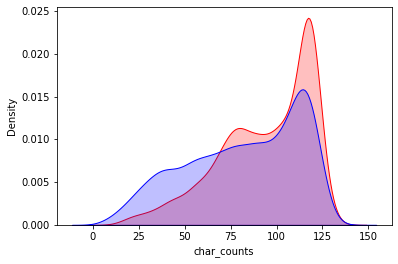

In [ ]:
sns.kdeplot(train[train['target'] == 1]['char_counts'], shade=True, color='red')
sns.kdeplot(train[train['target'] == 0]['char_counts'], shade=True, color= 'blue')

Data Cleaning

In [ ]:
def remove_tweet_username(df):
    return re.sub('@[^\s]+','', df)

def make_lower(df):
    return df.lower()

def cont_exp(df):
    return contractions.fix(df)

def make_string(df):
    return str(df)

def remove_url(df):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , df)

def remove_email(df):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", df)

#Retweets
def remove_rt(df):
    df = str(df)
    return re.sub(r'\brt\b', "", df).strip()

def remove_html(df):
    return BeautifulSoup(df, 'lxml').get_text().strip()


def remove_dots(df):
    dot_pattern = re.compile(r'\.{1,}')
    single_dot = dot_pattern.sub(' ', df)
    return single_dot

def remove_special_chars(df):
    df = re.sub(r'[^\w]+', " ", df)
    df = ' '.join(df.split())
    
    return df

def make_base(df):
    df = str(df)
    x_list = []
    doc = nlp(df)

    for token in doc:
        lemma = token.lemma_
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text

        x_list.append(lemma)
    return ' '.join(x_list)

def spelling_correction(df):
    df = TextBlob(df).correct()
    return df

def resub(df):
    return re.sub("(.)\\1{2,}", "\\1", df)



def get_clean_data(df):
    df = remove_url(df)
    df = remove_email(df)
#    df = remove_special_chars(df)
    df = remove_html(df)
#    df = remove_dots(df)
#    df = make_base(df)
#    df = spelling_correction(df).raw_sentences[0]
    df = make_lower(df)
    df = make_string(df)
    df = cont_exp(df)
    df = remove_rt(df)
    df = resub(df)                             
    df = remove_tweet_username(df)
    
    return df

In [ ]:
train['text'] = train['text'].apply(get_clean_data)

In [ ]:
test['text'] = test['text'].apply(get_clean_data)

In [ ]:
train['text'] = train['text'].apply(remove_special_chars)
test['text'] = test['text'].apply(remove_special_chars)

In [ ]:
train['text'].head(20)

0     our deeds are the reason of this earthquake ma...
1                 forest fire near la ronge sask canada
2     all residents asked to shelter in place are be...
3     13 0 people receive wildfires evacuation order...
4     just got sent this photo from ruby alaska as s...
5     rockyfire update california hwy 20 closed in b...
6     flood disaster heavy rain causes flash floodin...
7     i am on top of the hill and i can see a fire i...
8     there is an emergency evacuation happening now...
9     i am afraid that the tornado is coming to our ...
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah wait a...
12    raining flooding florida tampabay tampa 18 or ...
13                flood in bago myanmar we arrived bago
14    damage to school bus on 80 in multi car crash ...
15                                       what is up man
16                                        i love fruits
17                                     summer is

In [ ]:
from gensim.parsing.preprocessing import STOPWORDS

In [ ]:
STOPWORDS.difference()

all_stopwords_gensim = STOPWORDS
sw_list = {"not"}
all_stopwords_gensim = STOPWORDS.difference(sw_list)

In [ ]:
# Use Gensim

from gensim.parsing.preprocessing import remove_stopwords

train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [ ]:
train.text

0                   deeds reason earthquake allah forgive
1                        forest near la ronge sask canada
2       residents asked shelter place notified officer...
3       13 0 people receive wildfires evacuation order...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    giant cranes holding bridge collapse nearby homes
7609    control wild fires california northern state t...
7610                 m1 94 01 04 utc 5km s volcano hawaii
7611    police investigating e bike collided car littl...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [ ]:
# попытка удалить все цифры из столбцов
train['text'] = train['text'].str.replace('\d+', '')
test['text'] = test['text'].str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


**WordClouds**

In [ ]:
def get_word_freqs(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

In [ ]:
real_data = get_word_freqs(train[train['target']==1], 'text')
real_data = ' '.join(real_data.index)
real_data

's û_ news disaster california suicide police people killed like hiroshima storm pm fires crash families train emergency bomb buildings mh nuclear attack video wildfire old accident bombing burning northern dead legionnaires bomber car war typhoon homes year obama new japan atomic today fatal years collapse forest mass debris man watch malaysia water near latest home m severe û confirmed injured city earthquake time oil warning spill world floods army th derailment migrants thunderstorm wreckage weather outbreak going evacuation flood saudi ûªs flooding investigators area missing bridge state death wounded suspect rescuers mosque wild charged hundreds kills island day drought anniversary murder report devastated boy damage heat lives terrorist air reunion got affected pkk deaths truck detonated plane life collision rain school airplane yr county says massacre terrorism officials live w calgary razed boat evacuated rd refugees look times flames hit caused survivors airport hurricane upd

<function matplotlib.pyplot.imshow>

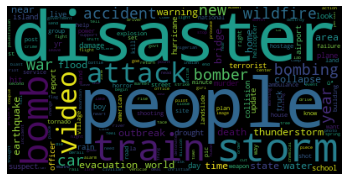

In [ ]:
wordcloud = WordCloud().generate(real_data)
plt.imshow(wordcloud)
plt.axis('off')
plt.imshow

In [ ]:
not_real_data = get_word_freqs(train[train['target']==0], 'text')
not_real_data = ' '.join(not_real_data.index)
not_real_data

's like û_ new body going want video people got love let time know day emergency man good w think lol world life way news burning û need best reddit work help read black great god content wreck hot feel ûªs right today fear look cross bags ass x bag fucking year night come death check getting bloody harm disaster school explode shit ruin screaming liked home wrecked bad panic face smoke head sinking buildings watch dead coming military police car self crush long crash stop war blood better m traumatised loud twister soon little fuck screamed storm curfew deluge fall live free hope o blew panicking nuclear said army bleeding game hazard battle destroy attack song girl run sunk desolation screams collide blown drown trouble ebay survive quarantine armageddon blazing burned lava real destruction oh bomb inundated big flattened bang things stock demolish flames movie shoulder thank phone twitter bagging electrocute services p high injury summer catastrophe meltdown destroyed trapped injuri

<function matplotlib.pyplot.imshow>

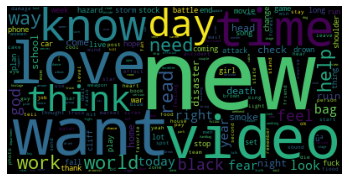

In [ ]:
wordcloud = WordCloud().generate(not_real_data)
plt.imshow(wordcloud)
plt.axis('off')
plt.imshow

**TF_IDF**

In [ ]:
text = train['text']
y = train['target']

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [ ]:
X.shape

(7613, 13745)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7, stratify=y)

**Word2Vec**

In [ ]:
!python -m spacy download en_core_web_lg 

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=105a419ab6a5f5e4107395c2ab1d06bc1c2e0c8ec17c8e3d66375bec4b577b8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-s4d60kzo/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import en_core_web_lg

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [ ]:
train['vectors'] = train['text'].apply(lambda x: get_vec(x))

In [ ]:
train.head()

,id,keyword,location,text,target,words_counts,char_counts,average_word_length,hashtags_counts,digits_counts,uppercase_counts,vectors
0,1,NaN,NaN,deeds reason earthquake allah forgive,1,13,57,4.384615,1,[],1,"[-0.577874, -0.020427203, -0.153596, -0.104262..."
1,4,NaN,NaN,forest near la ronge sask canada,1,7,32,4.571429,0,[.],0,"[0.0059129945, -0.12560566, -0.195046, -0.3924..."
2,5,NaN,NaN,residents asked shelter place notified officer...,1,22,112,5.090909,0,[.],0,"[0.07983147, 0.06994864, -0.0071826326, -0.000..."
3,6,NaN,NaN,people receive wildfires evacuation orders c...,1,8,57,7.125000,1,"[13,000]",0,"[-0.19421284, 0.1704717, -0.02339843, -0.21402..."
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,16,72,4.500000,2,[],0,"[-0.15872057, -0.08627854, 0.112908565, -0.068..."


In [ ]:
X = train['vectors'].to_numpy()
X = X.reshape(-1, 1)

In [ ]:
X.shape

(7613, 1)

In [ ]:
X 

array([[array([-5.77874005e-01, -2.04272028e-02, -1.53595999e-01, -1.04262009e-01,
               -1.44024193e-01, -1.37373477e-01, -1.06920168e-01,  2.04964593e-01,
                7.50923976e-02,  1.76424599e+00, -1.45140260e-01, -6.52392581e-02,
                5.92520013e-02, -1.35400025e-02, -4.37323987e-01,  1.74502209e-01,
               -1.38242006e-01,  2.08994389e-01,  2.81709991e-02,  2.87463814e-01,
                3.05527952e-02, -2.55371213e-01,  1.56000197e-01,  1.25563398e-01,
                1.16769195e-01,  1.21846400e-01, -4.64945994e-02,  9.73300040e-02,
               -1.59935996e-01,  2.78200001e-01,  1.99025981e-02,  3.59392017e-01,
               -2.74740994e-01,  2.14947984e-01,  1.99404985e-01,  6.23102002e-02,
               -1.69165805e-01, -2.74808053e-02, -1.86983988e-01,  2.99068004e-01,
               -2.09323600e-01, -2.78442413e-01,  1.99406400e-01, -1.23307206e-01,
               -1.58781588e-01, -3.26853991e-01,  1.10190012e-01,  2.85766184e-01,
    

In [ ]:
y = train['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7, stratify=y)

# **Вариант 3**

In [ ]:
import numpy as np # модуль для загрузки файлов в colab
import pandas as pd #библиотека для работы с таблицами pandas
from google.colab import files #библиотека для работы с массивами данных
import json

from sklearn.model_selection import train_test_split
import tensorflow as tf # импортируем tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.utils import plot_model, get_file, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import csv # импортируем модуль для удобной работы с файлами
import matplotlib as mpl
import matplotlib.pyplot as plt #Отрисовка изображений
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [ ]:
def Data_Update(reviews): #преодбработка данных
    global NUM_WORDS
    global tokenizer
    # создадим словарь для преобразования оценки из шкалы  5-1 в  шкалу positive - negative
    # используем 0 для класса негативных отзывов, 1 для класса позитивных отзывов
    label_to_binary = {1: 1, 0: 0}
    # создадим новую колонку в DataFramкe
    reviews['is_positive'] = reviews['target'].apply(lambda x: label_to_binary[x])
    # выделим наши тексты (признаковые описания) и класс, который нужно предсказывать
    X = reviews['text']
    Y = reviews['is_positive']
    # разделим наши данные на обучающую и валидационную выборки
    train_index, val_index = train_test_split(np.arange(reviews.shape[0]))
    trainX, testX = X[train_index], X[val_index]
    trainY, testY = Y[train_index], Y[val_index]
    NUM_WORDS = 1000 # константа, максимальное количество слов, которые будет учитывать наша модель

    
    return trainX, trainY, testY, testX 

In [ ]:
trainX, trainY, testY, testX = Data_Update(reviews)

In [ ]:
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

5709
5709
1904
1904


In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testY.shape)
print(testX.shape)

(5709,)
(5709,)
(1904,)
(1904,)


In [ ]:
# Подключаем керасовский токенизатор и собираем словарь индексов
def Create_and_save_tokenizer(trainX, # база отзывов
                              maxWordsCount = None, # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
                              load_flag = False,    # необходимость загрузить готовый токенайзер ранее обученный на этих данных
                              ):
    if load_flag:
        tok_path = tf.keras.utils.get_file(origin='http://dataudt.ru/datasets/tokenizer_for_kaleydoskop.json', fname='tokenizer_for_kaleydoskop.json')
        with open(tok_path) as f:
            data = json.load(f)
            tokenizer = tokenizer_from_json(data)
    else:
        tokenizer = Tokenizer(num_words=maxWordsCount, # максимальное количество слов, которые будет учитывать наш токенайзер
                            lower=True, # приводятся ли все символы к нижнему регситру
                            split=' ', # символ, по которому происходит разделение на слова (токены)
                            oov_token='unknown', # токен для неизвестных слов 
                            char_level=False, # являются ли токенами отдельные буквы
                            filters='"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff' # символы, которые он токенайзер будет фильтровать
                            )
        tokenizer.fit_on_texts(trainX) # + trainX1) # загружаем в токенизатор список отзывов для сборки словаря частотности
    vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
    vocabularySize = len(vocabularyItems)+1 # размер словаря
    print(f'Фрагмент словаря : {vocabularyItems[:50]}')
    print(f'Размер словаря : {vocabularySize}')
    return tokenizer, vocabularySize

In [ ]:
# если задать load_flag = True, то можно загрузить токенайзер ранее обученный на этих данных, с сервера университета
tokenizer, vocabularySize = Create_and_save_tokenizer(np.concatenate((trainX,testX),axis=0), maxWordsCount = 10000)

Фрагмент словаря : [('unknown', 4546), ('t', 2), ('co', 3), ('http', 4), ('the', 5), ('a', 6), ('in', 7), ('to', 8), ('of', 9), ('and', 10), ('i', 11), ('is', 12), ('for', 13), ('on', 14), ('you', 15), ('my', 16), ('with', 17), ('that', 18), ('it', 19), ('at', 20), ('by', 21), ('this', 22), ('from', 23), ('https', 24), ('are', 25), ('be', 26), ('was', 27), ('have', 28), ('like', 29), ('amp', 30), ('as', 31), ('up', 32), ('me', 33), ('but', 34), ('just', 35), ('so', 36), ('not', 37), ('your', 38), ('no', 39), ('out', 40), ('after', 41), ('will', 42), ('all', 43), ('has', 44), ('an', 45), ('fire', 46), ("i'm", 47), ('when', 48), ('if', 49), ('we', 50)]
Размер словаря : 23215


In [ ]:
# метод для токенизации данных
def Tokenized_data(data_token, tokenizer, maxLen): 
    # Устанавливаем закодированные входные данные
    tokenizedDatas = tokenizer.texts_to_sequences(data_token) # разбиваем текст вопросов на последовательности индексов
    maxLenData = max([ len(x) for x in tokenizedDatas]) # уточняем длину самого большого элемента последовательности
    # Делаем последовательности одной длины, заполняя нулями более короткие вопросы
    if maxLen > maxLenData: maxLenData = maxLen
    paddedDatas = pad_sequences(tokenizedDatas, maxlen=maxLenData, padding='post')
    # Предподготавливаем данные для входа в сеть
    dataForInput = np.array(paddedDatas) # переводим в numpy массив
    return dataForInput, maxLenData

In [ ]:
# метод для переводa в one hot encoding 
def Updata_to_OHE(dataY): 
    oneHotdataY = to_categorical(dataY) # переводим в one hot vector
    oneHotdataY = np.array(oneHotdataY) # и сохраняем в виде массива numpy
    return oneHotdataY

In [ ]:
# Подготовим данные для обучающей выборки
trainX_ForInput, maxLenData = Tokenized_data(trainX, tokenizer, 0)
trainY_OHE = Updata_to_OHE(trainY)
# Подготовим данные для тестовой выборки
testX_ForInput, max_test_LenData = Tokenized_data(testX, tokenizer, maxLenData)


In [ ]:
testY_OHE = Updata_to_OHE(testY)

In [ ]:
print(trainX_ForInput.shape)
print(trainY_OHE.shape)
print(testY_OHE.shape)
print(testX_ForInput.shape)

(5709, 33)
(5709, 2)
(1904, 2)
(1904, 33)


In [ ]:
def Plot_train_history(history, title):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(accuracy))

    plt.figure()

    plt.plot(epochs, accuracy, 'b', label='Доля верных ответов на обучающем наборе')
    plt.plot(epochs, val_accuracy, 'r', label='Доля верных ответов на проверочном наборе')
    plt.title(title)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()

    plt.show()

LSTM

In [ ]:
def Create_LSTM_Model(embeding_size, maxLenData, maxWordsCount = 10000):
    modelEL = Sequential() # создаём последовательную модель нейросети

    # преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
    modelEL.add(Embedding(maxWordsCount, embeding_size, input_length=maxLenData ))

    modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
    modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
    modelEL.add(LSTM(10))
    modelEL.add(Dense(2, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

    # Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
    modelEL.compile(optimizer='rmsprop', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    return modelEL

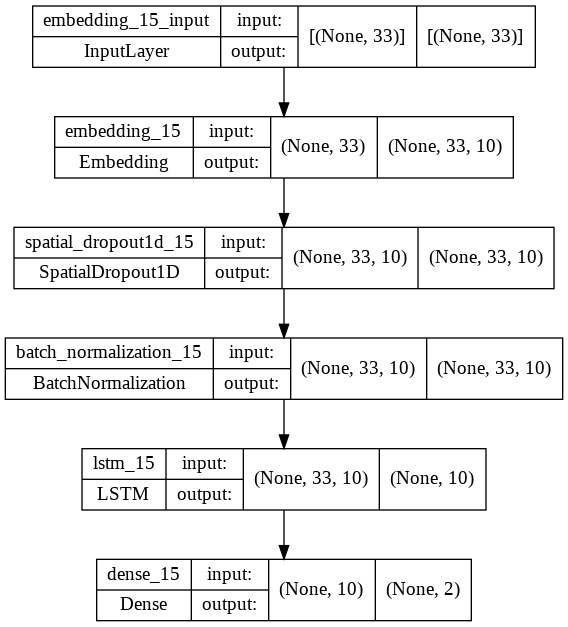

In [ ]:
# Создадим экземпляр модели нейронной сети
LSTM_Model = Create_LSTM_Model(10, maxLenData)
# и построим график для визуализации слоев и связей между ними
plot_model(LSTM_Model, to_file='LSTM_Model.png', show_shapes=True) 

In [ ]:
# Обучаем сеть с указанием обучающей выборки, количества эпох, размера минибатча для подачи сети, и размера валидационной выборки
history_LSTM_Model = LSTM_Model.fit(trainX_ForInput, trainY_OHE, epochs=1000, batch_size=200, validation_split=0.2)

Epoch 1/1000
23/23 [==============================] - 4s 46ms/step - loss: 0.6832 - accuracy: 0.5680 - val_loss: 0.6867 - val_accuracy: 0.5779
Epoch 2/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.6618 - accuracy: 0.6194 - val_loss: 0.6770 - val_accuracy: 0.5779
Epoch 3/1000
23/23 [==============================] - 0s 22ms/step - loss: 0.5647 - accuracy: 0.7830 - val_loss: 0.6324 - val_accuracy: 0.6462
Epoch 4/1000
23/23 [==============================] - 1s 22ms/step - loss: 0.4591 - accuracy: 0.8489 - val_loss: 0.5929 - val_accuracy: 0.6979
Epoch 5/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.4017 - accuracy: 0.8758 - val_loss: 0.6334 - val_accuracy: 0.6708
Epoch 6/1000
23/23 [==============================] - 1s 22ms/step - loss: 0.3619 - accuracy: 0.8879 - val_loss: 0.6453 - val_accuracy: 0.6743
Epoch 7/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.3328 - accuracy: 0.8986 - val_loss: 0.6586 - val_accuracy: 0.6813

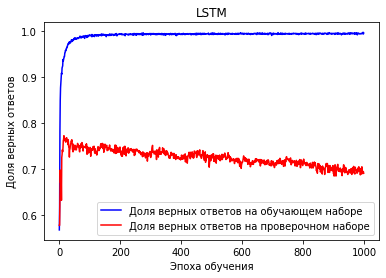

In [ ]:
Plot_train_history(history_LSTM_Model, 'LSTM')

In [ ]:
LSTM_Model.save('/content/drive/My Drive/datasets/LSTM_Conv1D/LSTM_Model.h5') # сохраним модель по необходимости
# LSTM_Model = load_model('/content/drive/My Drive/datasets/LSTM_Conv1D/LSTM_Model.h5') # загрузим модель по необходимости

Bidirectional

In [ ]:
def Create_Bidirectional_Model(embeding_size, maxLenData, maxWordsCount = 10000):
    modelEL = Sequential() # создаём последовательную модель нейросети

    # преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
    modelEL.add(Embedding(maxWordsCount, embeding_size, input_length=maxLenData ))

    modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
    modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
    modelEL.add(Bidirectional(LSTM(100)))
    #modelEL.add(Bidirectional(LSTM(10)))
    #modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
    #modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
    #modelEL.add(Bidirectional(LSTM(10)))
    modelEL.add(Dense(2, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

    # Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
    modelEL.compile(optimizer='rmsprop', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    return modelEL

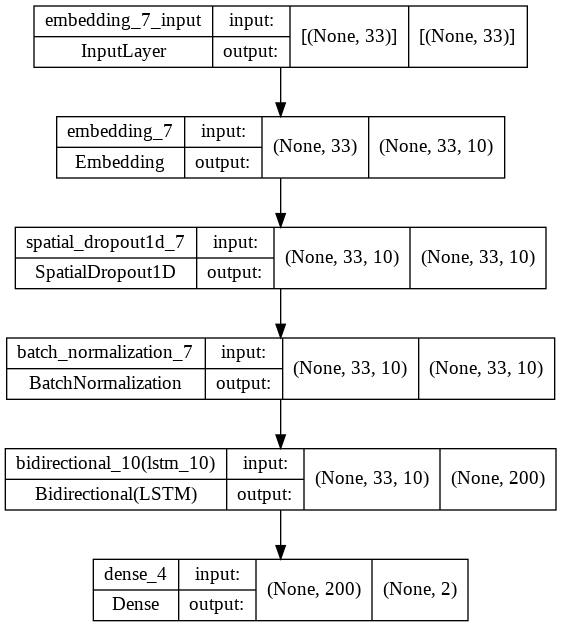

In [ ]:
# Создадим экземпляр модели нейронной сети
Bidirectional_Model = Create_Bidirectional_Model(10, maxLenData)
# и построим график для визуализации слоев и связей между ними
plot_model(Bidirectional_Model, to_file='Bidirectional_Model.png', show_shapes=True) 

In [ ]:
# Обучаем сеть с указанием обучающей выборки, количества эпох, размера минибатча для подачи сети, и размера валидационной выборки
history_Bidirectional_Model = Bidirectional_Model.fit(trainX_ForInput, trainY_OHE, epochs=1000, batch_size=180, validation_split=0.2)

Epoch 1/1000
26/26 [==============================] - 11s 221ms/step - loss: 0.6051 - accuracy: 0.6731 - val_loss: 0.6678 - val_accuracy: 0.5771
Epoch 2/1000
26/26 [==============================] - 5s 175ms/step - loss: 0.4457 - accuracy: 0.7979 - val_loss: 0.6554 - val_accuracy: 0.5771
Epoch 3/1000
26/26 [==============================] - 5s 174ms/step - loss: 0.3567 - accuracy: 0.8507 - val_loss: 0.6438 - val_accuracy: 0.5788
Epoch 4/1000
26/26 [==============================] - 5s 175ms/step - loss: 0.3006 - accuracy: 0.8745 - val_loss: 0.6357 - val_accuracy: 0.5981
Epoch 5/1000
26/26 [==============================] - 4s 173ms/step - loss: 0.2559 - accuracy: 0.8999 - val_loss: 0.6162 - val_accuracy: 0.6392
Epoch 6/1000
26/26 [==============================] - 5s 174ms/step - loss: 0.2231 - accuracy: 0.9159 - val_loss: 0.5863 - val_accuracy: 0.7067
Epoch 7/1000
26/26 [==============================] - 4s 173ms/step - loss: 0.1908 - accuracy: 0.9245 - val_loss: 0.5839 - val_accuracy

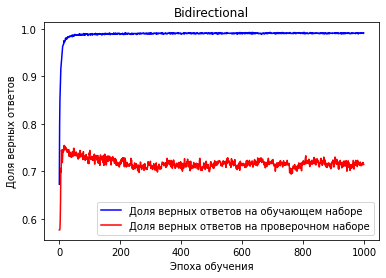

In [ ]:
Plot_train_history(history_Bidirectional_Model, 'Bidirectional')

In [ ]:
history_Bidirectional_Model = Bidirectional_Model.fit(trainX_ForInput, trainY_OHE, epochs=300, batch_size=200, validation_split=0.2)

Epoch 1/300
23/23 [==============================] - 5s 204ms/step - loss: 0.0162 - accuracy: 0.9899 - val_loss: 1.8046 - val_accuracy: 0.7198
Epoch 2/300
23/23 [==============================] - 5s 205ms/step - loss: 0.0179 - accuracy: 0.9899 - val_loss: 1.8577 - val_accuracy: 0.7145
Epoch 3/300
23/23 [==============================] - 5s 199ms/step - loss: 0.0156 - accuracy: 0.9906 - val_loss: 1.8271 - val_accuracy: 0.7128
Epoch 4/300
23/23 [==============================] - 5s 198ms/step - loss: 0.0157 - accuracy: 0.9908 - val_loss: 1.6905 - val_accuracy: 0.7102
Epoch 5/300
23/23 [==============================] - 5s 202ms/step - loss: 0.0154 - accuracy: 0.9897 - val_loss: 1.8095 - val_accuracy: 0.7119
Epoch 6/300
23/23 [==============================] - 5s 198ms/step - loss: 0.0162 - accuracy: 0.9917 - val_loss: 1.8376 - val_accuracy: 0.7137
Epoch 7/300
23/23 [==============================] - 5s 201ms/step - loss: 0.0183 - accuracy: 0.9912 - val_loss: 1.7817 - val_accuracy: 0.7154

In [ ]:
Bidirectional_Model.save('/content/drive/My Drive/datasets/LSTM_Conv1D/Bidirectional_Model.h5') # сохраним модель по необходимости
# Bidirectional_Model = load_model('/content/drive/My Drive/datasets/LSTM_Conv1D/Bidirectional_Model.h5') # загрузим модель по необходимости

Conv1D

In [ ]:
def Create_Conv1D_Model(embeding_size, maxLenData, maxWordsCount = 10000):
    modelEC = Sequential() # создаём последовательную модель нейросети

    # преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
    modelEC.add(Embedding(maxWordsCount, embeding_size, input_length=maxLenData ))

    modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
    modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
    modelEC.add(Conv1D(120, 4, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
    modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
    modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
    modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
    modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    modelEC.add(Dense(1, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

    # Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
    modelEC.compile(optimizer='rmsprop', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    return modelEC

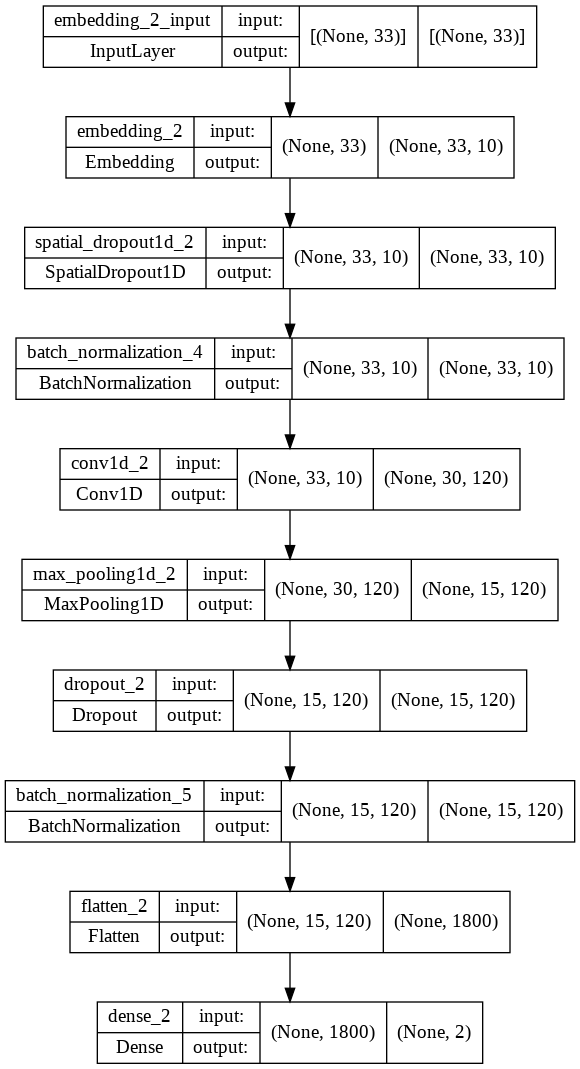

In [ ]:
# Создадим экземпляр модели нейронной сети
Conv1D_Model = Create_Conv1D_Model(10, maxLenData)
# и построим график для визуализации слоев и связей между ними
plot_model(Conv1D_Model, to_file='Conv1D_Model.png', show_shapes=True) 

In [ ]:
# Обучаем сеть с указанием обучающей выборки, количества эпох, размера минибатча для подачи сети, и размера валидационной выборки
history_Conv1D_Model = Conv1D_Model.fit(trainX_ForInput, trainY_OHE, epochs=1000, batch_size=180, validation_data=(testX_ForInput, testY_OHE))

Epoch 1/1000
32/32 [==============================] - 3s 37ms/step - loss: 0.7362 - accuracy: 0.6169 - val_loss: 0.6845 - val_accuracy: 0.5751
Epoch 2/1000
32/32 [==============================] - 1s 30ms/step - loss: 0.5549 - accuracy: 0.7423 - val_loss: 0.6773 - val_accuracy: 0.5751
Epoch 3/1000
32/32 [==============================] - 1s 33ms/step - loss: 0.4248 - accuracy: 0.8199 - val_loss: 0.6759 - val_accuracy: 0.5751
Epoch 4/1000
32/32 [==============================] - 1s 32ms/step - loss: 0.3353 - accuracy: 0.8642 - val_loss: 0.6818 - val_accuracy: 0.5751
Epoch 5/1000
32/32 [==============================] - 1s 33ms/step - loss: 0.2737 - accuracy: 0.8928 - val_loss: 0.6775 - val_accuracy: 0.5751
Epoch 6/1000
32/32 [==============================] - 1s 33ms/step - loss: 0.2242 - accuracy: 0.9194 - val_loss: 0.6761 - val_accuracy: 0.5751
Epoch 7/1000
32/32 [==============================] - 1s 32ms/step - loss: 0.1864 - accuracy: 0.9296 - val_loss: 0.6745 - val_accuracy: 0.5751

KeyboardInterrupt: ignored

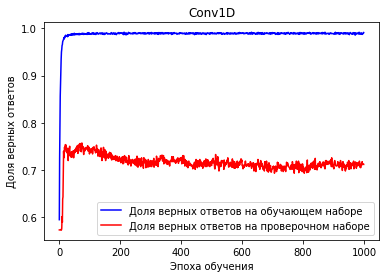

In [ ]:
Plot_train_history(history_Conv1D_Model, 'Conv1D')

In [ ]:
# Обучаем сеть с указанием обучающей выборки, количества эпох, размера минибатча для подачи сети, и размера валидационной выборки
history_Conv1D_Model = Conv1D_Model.fit(trainX_ForInput, trainY_OHE, epochs=1000, batch_size=200, validation_split=0.2)

Epoch 1/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.0192 - accuracy: 0.9908 - val_loss: 1.9394 - val_accuracy: 0.7820
Epoch 2/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0192 - accuracy: 0.9893 - val_loss: 1.9555 - val_accuracy: 0.7837
Epoch 3/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0218 - accuracy: 0.9886 - val_loss: 1.9854 - val_accuracy: 0.7811
Epoch 4/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0233 - accuracy: 0.9880 - val_loss: 1.9248 - val_accuracy: 0.7855
Epoch 5/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.0225 - accuracy: 0.9893 - val_loss: 2.0064 - val_accuracy: 0.7785
Epoch 6/1000
23/23 [==============================] - 1s 33ms/step - loss: 0.0211 - accuracy: 0.9888 - val_loss: 2.0155 - val_accuracy: 0.7820
Epoch 7/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0227 - accuracy: 0.9880 - val_loss: 2.0151 - val_accuracy: 0.7820

In [ ]:
#Conv1D_Model.save('/content/drive/My Drive/datasets/LSTM_Conv1D/Conv1D_Model2.h5') # сохраним модель по необходимости
Conv1D_Model = load_model('/content/drive/My Drive/datasets/LSTM_Conv1D/Conv1D_Model2.h5') # загрузим модель по необходимости

In [ ]:
def Prediction_model(test_data): # предсказываем значения
    try:
        # x_test_raw = pd.Series(test_data_reviews)
        x_test_raw = test_data['text']
        x_test_tok = tokenizer.texts_to_matrix(x_test_raw)
        
        # получим предсказания модели
        pred = Conv1D_Model.predict(x_test_tok)
        pred = np.round(pred).astype(np.int)
        print('Прогноз тестовых данных сформирован успешно!')
        return pred 
    except:
        print('При формировании прогноза на тестовых данных произошла ошибка!')
        return 0

In [ ]:
# оформить результат и отправить на Kaggle
def Send_results(pred_data_my):
    try:
        predUnscaled = pred_data_my.squeeze()
        # создаём датафрейм в нужном формате
        submission = pd.DataFrame({"Id":range(1,len(predUnscaled)+1),"target":predUnscaled})
        
        submission.head()
        # сохраняем его как csv
        sample_submission = submission.to_csv('/content/drive/MyDrive/datasets/nlp-getting-started/sample_submission.csv', sep=',', index=False, header=True)
        # отправляем на соревнование
        !kaggle competitions submit -c nlp-getting-started -f sample_submission.csv -m "Message"
        print('\n Расчитанные данные успешно отправлены! ')
        
    except:
        print('Отправка расчетных данных не прошла! ')  

In [ ]:
prediction_data = Prediction_model(test_data) # получим прогноз на тестовой выбоке

При формировании прогноза на тестовых данных произошла ошибка!
